<a href="https://colab.research.google.com/github/djm3622/bayesDL/blob/main/BayesLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports/Setup





In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [ ]:
np.random.seed(42)

### Synthetic Data

Create synthetic data along with ground truth.

In [ ]:
k, m, b = 1/2, 2/3, 5
n = 20
scaled_of_noise = 15

X_ground = np.concatenate([np.arange(1, n, 1)[:, None]**2, np.arange(1, n, 1)[:, None], np.ones(n-1)[:, None]], axis=1)
w = np.array([k, m, b])
noise = scaled_of_noise * np.random.randn(X_ground.shape[0])

In [ ]:
y_ground = (X_ground @ w)[: , None]
y_noise_ground = (X_ground @ w + noise)[: , None]

### Classic Forumulation

Closed form solution for linear regression.

In [ ]:
closed_form_LR = np.linalg.inv(X_ground.T @ X_ground) @ X_ground.T @ y_noise_ground

*Extension of data space.*

In [ ]:
X = np.concatenate([np.arange(-20, 40, 1)[:, None]**2, np.arange(-20, 40, 1)[:, None], np.ones(60)[:, None]], axis=1)
noise = scaled_of_noise * np.random.randn(X.shape[0])
y_noise = (X @ w + noise)[: , None]

*Get CI along axis.*

In [ ]:
t = stats.t.ppf(1-0.05/2, n-w.shape[0])

s = np.sqrt((1/(n-w.shape[0])) * (y_noise_ground - X_ground @ closed_form_LR).T @ (y_noise_ground - X_ground @ closed_form_LR))

In [ ]:
def get_CI(vec):
  diff = t * s * (np.sqrt((1 + vec @ np.linalg.inv(X_ground.T @ X_ground) @ vec.T)))
  lower_bound = vec @ closed_form_LR - diff
  upper_bound = vec @ closed_form_LR + diff
  return np.concatenate([lower_bound, upper_bound], axis=1)[0]

In [ ]:
CI = np.apply_along_axis(get_CI, axis=1, arr=X)
mu_CLR = X @ closed_form_LR

### Bayes Formulation

Closed form solution for Bayes linear regression.

In [ ]:
a, beta = 1, 1

lamda = a/beta
closed_form_bayes = np.linalg.inv(X_ground.T @ X_ground + lamda * np.eye(3)) @ X_ground.T @ y_noise_ground

Get HPD along axis.

In [ ]:
sigma_w = np.linalg.inv((beta * X_ground.T @ X_ground + a*np.eye(3)))

In [ ]:
def get_HPD(vec):
  std = np.sqrt((1/beta) + vec.T @ sigma_w @ vec)
  lower_bound = (vec @ closed_form_bayes) - (2 * std)
  upper_bound = (vec @ closed_form_bayes) + (2 * std)
  return np.concatenate([lower_bound[:,None], upper_bound[:,None]], axis=1)[0]

In [ ]:
HPD = np.apply_along_axis(get_HPD, axis=1, arr=X)
mu_BLR = X @ closed_form_bayes

### Model Comparisons

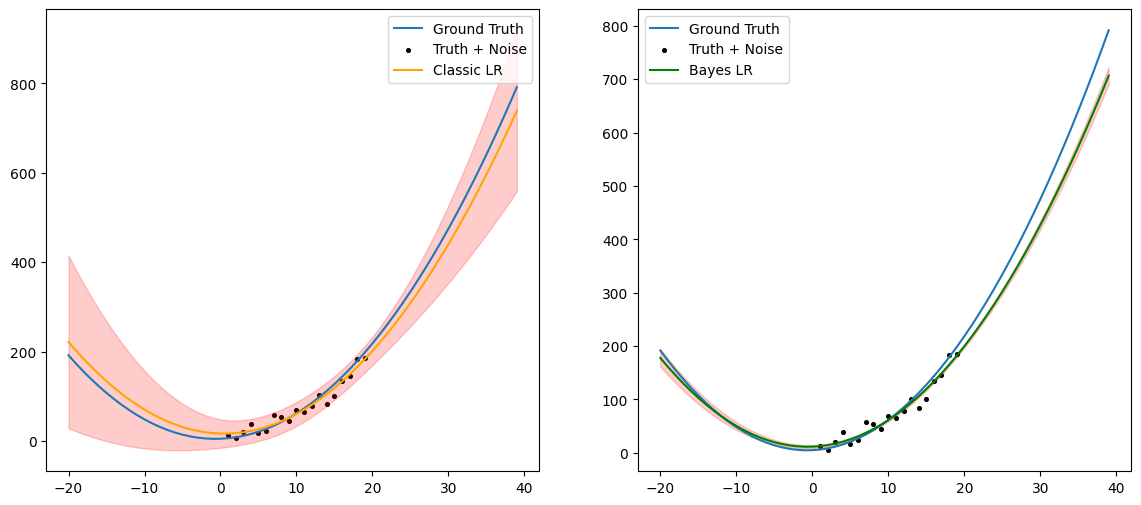

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(X[:, 1], (X @ w)[: , None], label='Ground Truth')
axs[0].scatter(X_ground[:, 1], y_noise_ground, color='black', label="Truth + Noise", s=7)
axs[0].plot(X[:, 1], mu_CLR, label='Classic LR', color='orange')
axs[0].fill_between(X[:, 1], CI[:, 0], CI[:, 1], color='red', alpha=0.2)
axs[0].legend()

axs[1].plot(X[:, 1], (X @ w)[: , None], label='Ground Truth')
axs[1].scatter(X_ground[:, 1], y_noise_ground, color='black', label="Truth + Noise", s=7)
axs[1].plot(X[:, 1], mu_BLR, label='Bayes LR', color='green')
axs[1].fill_between(X[:, 1], HPD[:, 0], HPD[:, 1], color='red', alpha=0.2)
_ = axs[1].legend()